In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from concurrent.futures import ThreadPoolExecutor, as_completed

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



X = pd.read_csv('data/features__power.csv')
X

,dataset_name,f__pymfe.statistical.nr_disc,f__pymfe.landmarking.linear_discr.mean,f__pymfe.model-based.leaves_per_class.min,f__pymfe.landmarking.linear_discr.max,f__pymfe.landmarking.worst_node.min,f__pymfe.model-based.leaves_per_class.max,f__pymfe.landmarking.elite_nn.max,f__pymfe.landmarking.elite_nn.mean,f__pymfe.model-based.var_importance.mean,...,f__pymfe.statistical.t_mean.min,f__pymfe.info-theory.class_ent,f__pymfe.landmarking.one_nn.skewness,f__pymfe.landmarking.linear_discr.kurtosis,f__pymfe.landmarking.one_nn.kurtosis,f__pymfe.landmarking.elite_nn.kurtosis,f__pymfe.landmarking.random_node.skewness,f__pymfe.general.nr_bin,f__pymfe.general.freq_class.skewness,f__pymfe.statistical.sparsity.skewness
0,openml__Amazon_employee_access__34539,-0.717694,-0.058807,0.300973,-0.079564,0.377100,0.325937,-0.032274,0.000554,-0.346265,...,0.001745,-1.809913,-0.060385,-0.054699,0.011987,0.056088,0.045381,-0.853296,-0.191565,0.002694
1,openml__Australian__146818,-0.717694,0.331661,1.057782,0.367881,0.740437,0.434462,0.826934,1.012217,0.851732,...,0.016592,-0.357676,1.098362,-1.021351,-0.555947,0.855549,0.123710,1.242876,-0.191565,-0.448708
2,openml__GesturePhaseSegmentationProcessed__14969,1.259443,-1.817603,-0.986897,-1.902905,-1.003490,-1.269771,-1.487765,-1.321889,-0.921948,...,0.001690,0.862327,2.441022,0.364990,1.384655,-0.811672,0.987377,-0.853296,-0.393988,0.445351
3,openml__JapaneseVowels__3510,1.591767,1.524092,-1.384178,1.181988,-1.404434,-1.512919,-1.618540,-1.479737,-0.205008,...,-0.003942,1.374531,1.383925,2.366672,2.342461,0.508524,-0.608309,-0.853296,1.237712,0.792441
4,openml__LED-display-domain-7digit__125921,1.548884,0.395620,-1.313345,0.528443,-1.330861,-1.745805,-1.836716,-1.835557,0.649553,...,0.004824,1.450634,-0.651210,-1.129312,0.390232,-0.654665,-0.479809,1.480583,-3.100597,-0.028891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,openml__walking-activity__9945,1.259443,-2.557019,-1.474528,-2.391917,-1.829047,-1.879539,-2.532650,-2.508885,1.352984,...,-0.014311,1.694992,0.765007,-0.749477,-0.788399,0.402050,0.413781,-0.853296,2.107292,-1.141123
130,openml__wall-robot-navigation__9960,1.016480,-0.528458,-1.381179,-0.864932,-0.640228,-0.233640,-0.433528,-0.243242,-0.714794,...,0.008032,0.488152,0.279138,0.957285,0.014126,0.308066,0.657043,-0.853296,-0.454751,-0.038036
131,openml__wdbc__9946,-0.717694,1.630453,0.765622,1.629772,0.645144,0.707926,1.702328,2.001674,-0.879193,...,0.001723,-0.415777,-1.009984,1.566987,-1.482758,1.097915,0.168089,-0.853296,-0.191565,0.174857
132,openml__wilt__146820,-0.717694,-0.796536,0.932306,-0.968045,0.645144,0.547540,0.000875,0.153663,1.085436,...,0.139038,-1.859142,-0.577274,-0.585525,-1.244723,-1.902582,0.045381,-0.853296,-0.191565,-0.489966


In [37]:
targets = pd.read_csv('data/metrics__perf_abs.csv')
models = targets.columns[1:]

In [38]:
targets

,dataset_name,LinearModel__absperf,RandomForest__absperf,XGBoost__absperf,rtdl_FTTransformer__absperf,rtdl_MLP__absperf,rtdl_ResNet__absperf
0,openml__Amazon_employee_access__34539,1.0,1.0,1.0,1.0,1.0,1.0
1,openml__Australian__146818,1.0,1.0,0.0,0.0,1.0,0.0
2,openml__GesturePhaseSegmentationProcessed__14969,0.0,0.0,0.0,0.0,0.0,0.0
3,openml__JapaneseVowels__3510,1.0,0.0,1.0,1.0,1.0,1.0
4,openml__LED-display-domain-7digit__125921,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
129,openml__walking-activity__9945,0.0,0.0,0.0,0.0,0.0,0.0
130,openml__wall-robot-navigation__9960,0.0,1.0,1.0,0.0,1.0,1.0
131,openml__wdbc__9946,1.0,1.0,1.0,1.0,1.0,1.0
132,openml__wilt__146820,1.0,1.0,1.0,1.0,1.0,1.0


In [39]:
y = targets[['dataset_name', 'XGBoost__absperf']]
df = X.merge(y, how='inner', on='dataset_name')
df = df.drop(columns=['dataset_name'])
X = df[df.columns[:-1]].values
y = df['XGBoost__absperf'].values

In [ ]:

# # Load and prepare data
# data = load_breast_cancer()
# X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Configuration
NUM_FEATURES = X.shape[1]
CF_STEPS = 500
TRAIN_EPOCHS = 300
ALPHA = 0.01  # Feature count penalty coefficient
DC = 0.2
# Define neural network model
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 2)
    
    def forward(self, x):
        return self.linear(x)

# Batched counterfactual generator
def generate_counterfactual_batch(model, x_original_batch, target_class_batch, mad, steps=CF_STEPS, distance_coef = DC):
    x_cf = x_original_batch.clone().detach().to(device).requires_grad_(True)
    optimizer = optim.Adam([x_cf], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    for _ in range(steps):
        optimizer.zero_grad()
        logits = model(x_cf)
        pred_loss = criterion(logits, target_class_batch)
        # Compute distance loss in a batched way
        distance_loss = (((x_cf - x_original_batch).abs() / mad).sum(dim=1)).mean()
        loss = pred_loss + distance_coef*distance_loss
        loss.backward()
        optimizer.step()
    return x_cf.detach()

# Evaluate a candidate feature subset (in this case, typically one feature)
def evaluate_feature_subset(feature_mask):
    if feature_mask.sum() == 0:
        return 0.0
    
    
    
    X_train_masked = X_train[:, feature_mask]
    #X_val_scaled = scaler.transform(X_val[:, feature_mask])

    # Convert to torch tensors
    X_train_tensor = torch.FloatTensor(X_train_masked).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    #X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)

    # Train the model on the selected feature subset
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = ClassificationModel(feature_mask.sum()).to(device)
    optimizer_model = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for _ in range(TRAIN_EPOCHS):
        for batch_X, batch_y in train_loader:
            optimizer_model.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer_model.step()
    
    # Compute median absolute deviation (MAD) for the training data
    med = torch.median(X_train_tensor, dim=0).values
    mad = torch.median(torch.abs(X_train_tensor - med) + 1e-6, dim=0).values

    # --- Batched counterfactual evaluation ---
    batch_instances = X_train_tensor
    model.eval()
    with torch.no_grad():
        logits = model(batch_instances)
        original_classes = torch.argmax(torch.softmax(logits, dim=-1), dim=-1)
    
    # Define target class as the opposite class
    target_tensor = ((original_classes + 1) % 2).to(device)
    # Generate counterfactuals for the entire batch at once
    cf_batch = generate_counterfactual_batch(model, batch_instances, target_tensor, mad, CF_STEPS)
    
    with torch.no_grad():
        logits_cf = model(cf_batch)
        cf_classes = torch.argmax(torch.softmax(logits_cf, dim=-1), dim=-1)
    
    correct = (cf_classes == target_tensor).float().sum().item()
    cf_accuracy = correct / X_train_tensor.shape[0]
    # Apply a penalty proportional to the fraction of features used (for one feature, penalty is constant)
    fitness = cf_accuracy
    return fitness

# New selection strategy: Evaluate each individual feature and select the top K
def select_top_k_features(K):
    fitness_results = {}
    # Evaluate each feature in parallel (each candidate mask uses a single feature)
    with ThreadPoolExecutor(max_workers=NUM_FEATURES) as executor:
        futures = {}
        for feat in range(NUM_FEATURES):
            # Create a mask with only this feature selected
            mask = np.zeros(NUM_FEATURES, dtype=bool)
            mask[feat] = True
            futures[executor.submit(evaluate_feature_subset, mask)] = feat

        for future in as_completed(futures):
            feat = futures[future]
            try:
                fitness = future.result()
                fitness_results[feat] = fitness
                print(f"Feature {feat} fitness: {fitness:.4f}")
            except Exception as e:
                print(f"Feature {feat} evaluation failed: {e}")

    # Sort features by fitness (higher is better)
    sorted_features = sorted(fitness_results.items(), key=lambda x: x[1], reverse=True)
    selected_features = np.zeros(NUM_FEATURES, dtype=bool)
    for i in range(min(K, len(sorted_features))):
        feat, fitness = sorted_features[i]
        selected_features[feat] = True
        print(f"Selected feature {feat} with fitness {fitness:.4f}")

    return selected_features, sorted_features

In [44]:
TOP_K = 5
final_selected_features, sorted_fitness = select_top_k_features(TOP_K)
print("Final selected features mask:", final_selected_features)

Feature 7 fitness: 0.0000
Feature 41 fitness: 1.0000
Feature 24 fitness: 1.0000
Feature 30 fitness: 1.0000
Feature 0 fitness: 0.0000
Feature 29 fitness: 1.0000
Feature 78 fitness: 0.0000
Feature 102 fitness: 0.0000
Feature 77 fitness: 0.0000
Feature 54 fitness: 0.0000
Feature 31 fitness: 0.0000
Feature 8 fitness: 1.0000
Feature 17 fitness: 1.0000
Feature 53 fitness: 0.0000
Feature 6 fitness: 0.0000
Feature 23 fitness: 0.0000
Feature 19 fitness: 1.0000
Feature 35 fitness: 0.0000
Feature 5 fitness: 0.0000
Feature 1 fitness: 1.0000
Feature 11 fitness: 1.0000
Feature 48 fitness: 1.0000
Feature 42 fitness: 0.0000
Feature 25 fitness: 0.0000
Feature 91 fitness: 0.0000
Feature 32 fitness: 0.0000
Feature 67 fitness: 0.0000
Feature 66 fitness: 0.0000
Feature 18 fitness: 0.0093
Feature 114 fitness: 1.0000
Feature 120 fitness: 0.0000
Feature 38 fitness: 0.0000
Feature 108 fitness: 0.0093
Feature 49 fitness: 0.0000
Feature 89 fitness: 0.0000
Feature 80 fitness: 0.0000
Feature 65 fitness: 0.0000
Fea

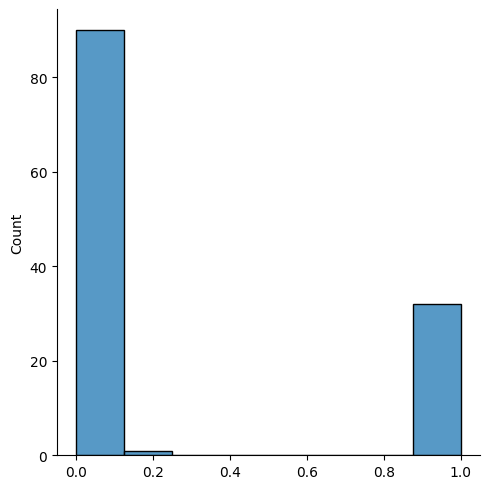

In [45]:
import seaborn as sns

sns.displot([x[1] for x in sorted_fitness])

In [14]:
sorted_fitness

[(20, 0.9996666666666667),
 (27, 0.9996666666666667),
 (7, 0.9996666666666667),
 (22, 0.9996666666666667),
 (23, 0.9996666666666667),
 (2, 0.021644688644688645),
 (13, 0.010655677655677657),
 (3, 0.010655677655677657),
 (29, 0.010655677655677657),
 (12, 0.010655677655677657),
 (19, -0.0003333333333333333),
 (9, -0.0003333333333333333),
 (8, -0.0003333333333333333),
 (21, -0.0003333333333333333),
 (26, -0.0003333333333333333),
 (14, -0.0003333333333333333),
 (25, -0.0003333333333333333),
 (1, -0.0003333333333333333),
 (15, -0.0003333333333333333),
 (10, -0.0003333333333333333),
 (4, -0.0003333333333333333),
 (16, -0.0003333333333333333),
 (28, -0.0003333333333333333),
 (11, -0.0003333333333333333),
 (5, -0.0003333333333333333),
 (17, -0.0003333333333333333),
 (0, -0.0003333333333333333),
 (6, -0.0003333333333333333),
 (18, -0.0003333333333333333),
 (24, -0.0003333333333333333)]